### 首先运行下基本的命令，检查下Tensorflow环境是否搭建成功

In [3]:
import tensorflow as tf

hello = tf.constant('Hello Tensorflow!')
with tf.Session() as sess:
    print(sess.run(hello))

b'Hello Tensorflow!'


### 模型选择

- 根据Capstone中给出例子[deep learning models for keras](https://github.com/fchollet/deep-learning-models)看了下其他人是如何使用Keras来预测的
- 选择VGG19,InceptionV3,Xception以及ResNet来根据上方的例子做一个简单的预测;
- 自定义一个函数根据不同的module name来预测，并输出图片及排名第一的概率；

In [12]:
# Tensorflow搭建成功，再试一下通过VGG19,InceptionV3,Xception以及ResNet预测一张图片
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
import h5py
import numpy as np
import cv2
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline 

def preditcByModuleName(module_name, image_path):
    model = None
    preprocess = imagenet_utils.preprocess_input # default  preprocess
    input_shape = (224, 224) # default shape
    x_coordinate = 220
    # 根据module name选择构建的模型及input shape和preprocessor
    if(module_name == 'vgg19'):
        model = VGG19(weights='imagenet')
    elif(module_name == 'resnet'):
        model = ResNet50(weights='imagenet')
    elif(module_name == 'xception'):
        model = Xception(weights='imagenet')
        input_shape = (299, 299)
        preprocess = xception.preprocess_input
        x_coordinate = 190
    elif(module_name == 'inception'):
        model = InceptionV3(weights='imagenet')
        input_shape = (299, 299)
        preprocess = inception_v3.preprocess_input
        x_coordinate = 190
    else:
        raise ValueError("Module name is not correct!")
    
    # 加载图片并对数据进行预处理    
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess(x)
    # 预测图片
    preds = model.predict(x)
    P = imagenet_utils.decode_predictions(preds)
    # 合成图片和预测结果并输出
    orig = cv2.imread(image_path)
    (imagenetID, label, prob) = P[0][0]
    cv2.putText(orig, "{}".format(module_name),(x_coordinate, 270), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    cv2.putText(orig, "Label: {}, {:.2f}%".format(label, prob * 100),(10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    cv_rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()



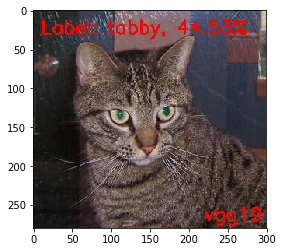

In [5]:
# Test vgg19
img_path = 'data/train/cat/cat.1.jpg'
preditcByModuleName('vgg19', img_path)

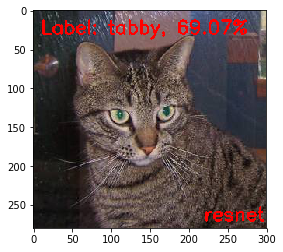

In [4]:
# Test ResNet
preditcByModuleName('resnet', img_path)

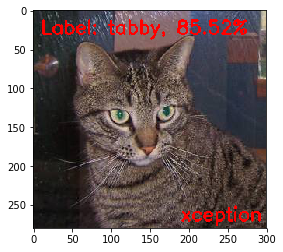

In [5]:
# Test xception
preditcByModuleName('xception', img_path)

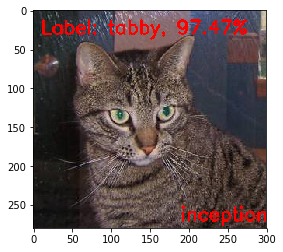

In [6]:
# Test Inception
preditcByModuleName('inception', img_path)

### 迁移学习

- 通过运行上方的代码，大概知道了各个模型的一个表现情况，因为VGG19的表现相对较差而，模型较大，训练起来会偏慢，所以放弃这个模型；
- 下面需要对剩下的三个模型进行迁移学习，首先我们获取三个模型的base部分，即不包含最后全连接层的模型；
- 然后我们用这些基础模型根据data generator来做预测得到3个模型的bottleneck_feature

In [20]:
# save features
def save_bottle_neck_features(filename, train_features, test_features, train_labels):
    with h5py.File("bottleneck_features/{}.hdf5".format(filename), "w") as f:
        dset = f.create_dataset("train", data=train_features)
        dset = f.create_dataset("test", data=test_features)
        dset = f.create_dataset("label", data=train_labels)
    

In [16]:
# 定义input_tensor
input_tensor = Input(shape=(224, 224, 3))
# 获取base model
resnet_base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
# 加一层pooling，不然数据太大了！而且可以防止拟合
model = Model(resnet_base_model.input, GlobalAveragePooling2D()(resnet_base_model.output))
# 记录当前时间
start_time = datetime.now()

train_data_path = 'data/train/'
test_data_path = 'data/test/'
train_data_size = 25000
test_data_size = 12500
image_size = (224, 224)

generator = ImageDataGenerator()

train_generator = generator.flow_from_directory(train_data_path, image_size, shuffle=False, batch_size=16)
test_generator = generator.flow_from_directory(test_data_path, image_size, shuffle=False, batch_size=16)

train_bottleneck_features = model.predict_generator(train_generator, train_data_size)
test_bottleneck_features = model.predict_generator(train_generator, test_data_size)

save_bottle_neck_features("restnet_bottleneck_features", train_bottleneck_features, test_bottleneck_features, 
                          train_generator.classes)
    
end_time = datetime.now()

print("Extract feature finished! Total consumed: {} ".format(end_time - start_time))

Found 25000 images belonging to 2 classes.
Found 0 images belonging to 0 classes.
Extrac feature finished! Total consumed: 0:57:18.320957 


In [24]:
# 定义input_tensor
input_tensor = Input(shape=(299, 299, 3))
# 预处理数据
input_tensor = Lambda(xception.preprocess_input)(input_tensor)
# 获取xception base model
xception_base_model = Xception(weights='imagenet', include_top=False, input_tensor=input_tensor)
model = Model(xception_base_model.input, GlobalAveragePooling2D()(xception_base_model.output))
# 重新定义image_size
image_size = (299, 299)
# 记录当前时间
start_time = datetime.now()

train_generator = generator.flow_from_directory(train_data_path, image_size, shuffle=False, batch_size=16)
test_generator = generator.flow_from_directory(test_data_path, image_size, shuffle=False, batch_size=16)

train_bottleneck_features = model.predict_generator(train_generator, train_data_size)
test_bottleneck_features = model.predict_generator(train_generator, test_data_size)

save_bottle_neck_features("xception_bottleneck_features", train_bottleneck_features, test_bottleneck_features, 
                          train_generator.classes)
    
end_time = datetime.now()

print("Extract feature finished! Total consumed: {} ".format(end_time - start_time))

Found 25000 images belonging to 2 classes.
Found 0 images belonging to 0 classes.
Extract feature finished! Total consumed: 1:51:56.502403 


In [25]:
# 定义input_tensor
input_tensor = Input(shape=(299, 299, 3))
# 预处理数据
input_tensor = Lambda(inception_v3.preprocess_input)(input_tensor)
# 获取inception base model
inception_base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor)
# 加一层pooling，不然数据太大了！而且可以防止拟合
model = Model(inception_base_model.input, GlobalAveragePooling2D()(inception_base_model.output))
# 记录当前时间
start_time = datetime.now()

train_bottleneck_features = model.predict_generator(train_generator, train_data_size)
test_bottleneck_features = model.predict_generator(train_generator, test_data_size)

save_bottle_neck_features("inception_bottleneck_features", train_bottleneck_features, test_bottleneck_features, 
                          train_generator.classes)
    
end_time = datetime.now()

print("Extract feature finished! Total consumed: {} ".format(end_time - start_time))

Extract feature finished! Total consumed: 1:13:46.941855 


In [ ]:
def model_train_and_predict(bottleneck_file_path):
    
    train_x = []
    train_y = []
    text_x = []
    
    with h5py.File(bottleneck_file_path, 'r') as h:
        train_x = np.array(h['train'])
        train_y = np.array(h['label'])
        text_x = np.array(h['test'])
    
    input_tensor = Input(train_x.shape[1:])
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmod')(x)
    model = Model(input_tensor, x)
    # compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # fit model
    model.fit(train_x, train_y, batch_size=120, nb_epoch=10, validation_split=0.2)
    # predict
    preds = model.predict(text_x)
    # generate kaggle submission file
    
    

In [40]:
train_x = []
train_y = []
text_x = []

with h5py.File('bottleneck_features\inception_bottleneck_features.hdf5', 'r') as h:
    train_x = np.array(h['train'])
    train_y = np.array(h['label'])
    text_x = np.array(h['test'])
    
print(train_x.shape, train_y.shape, text_x.shape)

(399880, 2048) (25000,) (199944, 2048)


In [41]:
train_x = np.concatenate(train_x, axis=1)
text_x = np.concatenate(text_x, axis=1)

input_tensor = Input(train_x.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)
# compile model
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
# fit model
model.fit(train_x, train_y, batch_size=120, epochs=10, validation_split=0.2)



AxisError: axis 1 is out of bounds for array of dimension 1